# REDUCEDHEATCARB analysis

This JupyterLabs notebook can be used for physics ifnormed machine learning analysis in the REDUCEDHEATCAB project.
Don't forget to install the requirements listed in [requirements.txt](../requirements.txt) first!

## Setting the stage

First several imports and variables need to be defined


### Imports and generic settings

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

%load_ext autoreload

    
from tqdm.notebook import tqdm

from gekko import GEKKO

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

from plotter import Plot
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget


from nfh_utils import *

# usually, two decimals suffice for displaying DataFrames (NB internally, precision may be higher)
pd.options.display.precision = 2

from rhc_analysis import Learner, Comfort

# rhc_preprocessed_poperties_file='rhc_preprocessed_properties_intv_5_min.parquet'
rhc_preprocessed_poperties_file='rhc_preprocessed_properties_intv_1_min.parquet'
#rhc_preprocessed_poperties_file='rhc_heat_dstr_preprocessed_properties.parquet'

home_BAG_data_file_path = 'buildings_properties_detailed.xlsx'
home_boilers_excel_file_path = "boilers.xlsx"
boiler_returntemp_load_efficiency_file_path = 'boiler_returntemp_load_efficiency.parquet'

regime_change_A1_file_path = 'homes_interventions_A1.xlsx'
regime_change_B1_file_path = 'homes_interventions_B1.xlsx'

# File for intermediate output (including preprocessing that may likely needs to migrate to the GEKKO model code for the what-if simulations)
rhc_heat_dstr_preprocessed_poperties_file='rhc_heat_dstr_preprocessed_properties.parquet'

rhc_analysis_results_file = 'rhc_results.parquet'
rhc_analysis_results_per_period_file = 'rhc_results_per_period.xlsx'

import logging 

# Clear any existing handlers to avoid duplicate logs
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Set up logging to the console only
logging.basicConfig(
    level=logging.WARNING,  # Adjust log level as necessary (DEBUG, INFO, WARNING, etc.)
    # level=logging.INFO,  # Adjust log level as necessary (DEBUG, INFO, WARNING, etc.)
    # level=logging.DEBUG,  # Adjust log level as necessary (DEBUG, INFO, WARNING, etc.)
    stream=sys.stderr,    # Send logs to stdout (you can also use sys.stderr if needed)
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
)

### Reading preprocessed interpolated properties from a parquet file

In [ ]:
%%time

# Attempt to read the Parquet file
try:
    df_prep = pd.read_parquet(
        rhc_preprocessed_poperties_file, 
        engine='pyarrow',
        dtype_backend='numpy_nullable'
        )
    print("File was successfully read without specifying compression codec.")
except Exception as e:
    print(f"Error reading file: {e}")

In [ ]:
#sorting the DataFrame index is needed to get good performance on certain filters
#this guarding code to check whether DataFrames are properly sorted
if not df_prep.index.is_monotonic_increasing:
    print('df needed index sorting')
    df_prep = df_prep.sort_index()  

In [ ]:
print(f"df_prep.count().sum(): {df_prep.count().sum():_}")

In [ ]:
df_prep.info()

In [ ]:
sorted(df_prep.columns.to_list())

In [ ]:
# visuaize all input data
df_plot = df_prep

In [ ]:
list(df_plot.index.unique('id').dropna())

In [ ]:
df_plot.index.unique('id').dropna()

In [ ]:
# df_plot.loc[[401632]][[prop for prop in df_plot.columns.values if prop.split('__')[-1] in ('degC', 'W', '0', 'bool', 'ppm', 'W_m_2')]]

In [ ]:
#Plot all properties from all sources for all ids
#Plot.dataframe_preprocessed_plot(df_plot.loc[[401632]][[prop for prop in df_plot.columns.values if prop.split('__')[-1] in ('degC', 'ppm', 'W_m_2')]], units_to_mathtext)

In [ ]:
mandatory_sourceprops =  ['batch_import_KNMI_temp_outdoor__degC', 
                          'batch_import_KNMI_sol_ghi__W_m_2',
                          'batch_import_KNMI_wind__m_s_1',
                          'batch_import_KNMI_air_outdoor__Pa',
                          'batch_import_remeha_temp_indoor__degC',
                          'batch_import_remeha_temp_ret__degC',
                          'batch_import_remeha_temp_flow__degC',
                          'batch_import_remeha_fan_rotations__min_1',
                          'batch_import_EDSN_actual_gas_std_hhv__J_m_3',
                          # 'device_p1-reader_g_use_cum__m3'
                         ]

In [ ]:
Plot.plot_missing_data_overview(df_prep, properties_include=mandatory_sourceprops, freq='1W', title_fontsize=8)

# Calculate additional properties 
We may have to move some of these calculations to inside the GEKKO Python model code (e.g. for the what-if scenario simulation)

## Calculate calculated_comfortable__bool

In [ ]:
%%time
%autoreload 2
# initially, we do not use occupancy yet
df_prep.loc[:,'calculated_comfortable__bool'] = Comfort.is_comfortable(
    df_prep['batch_import_remeha_temp_indoor__degC'], 
    df_prep['batch_import_remeha_temp_set__degC'], 
    target_ppd__pct=10, 
    # occupancy__bool=(df_prep['device_living_room_occupancy__p'] > 0)
)

In [ ]:
# Get an overview of True, False, and NaN values
df_prep['calculated_comfortable__bool'].value_counts(normalize=True, dropna=False).to_frame().T

In [ ]:
# Get an overview of True, False, and NaN values
df_prep['calculated_comfortable__bool'].value_counts(normalize=True, dropna=False).to_frame().T

In [ ]:
# Get an overview of True, False, and NaN values
df_prep['calculated_comfortable__bool'].groupby('id').value_counts(normalize=True, dropna=False).to_frame().unstack().T

## Use boiler-specific efficiency to calculate heat_ch__W

### Reading boiler efficiency data

In [ ]:
%%time
# Attempt to read the Parquet file
try:
    df_boiler_efficiency = pd.read_parquet(
        # boiler_returntemp_efficiency_file_path, 
        boiler_returntemp_load_efficiency_file_path, 
        engine='pyarrow',
        dtype_backend='numpy_nullable'
        )
    print("File was successfully read without specifying compression codec.")
except Exception as e:
    print(f"Error reading file: {e}")

In [ ]:
df_boiler_efficiency

### Lookup of momentary boiler efficiency from boiler-specific efficiency curves

In [ ]:
# Derive brand-specific min and max for load and return temperature
brand_specific_ranges = df_boiler_efficiency.reset_index().groupby('brand_model').agg({
    'rounded_load__%': ['min', 'max'],
    'rounded_temp_ret__degC': ['min', 'max']
})

In [ ]:
# Rename columns for clarity
brand_specific_ranges.columns = ['min_load__%', 'max_load__%', 'min_temp_ret__degC', 'max_temp_ret__degC']

In [ ]:
brand_specific_ranges

In [ ]:
%%time
# Merge df_prep with brand_specific_ranges to get the min/max values for each brand_model
df_prep = (df_prep
           .reset_index()
           .merge(brand_specific_ranges, on='brand_model', how='left')
           .set_index(['id', 'timestamp'])
           .sort_index())

In [ ]:
%%time
# Round return temperatures to whole degrees
df_prep['rounded_temp_ret__degC'] = (df_prep['batch_import_remeha_temp_ret__degC']
                                     .round()
                                     .clip(lower=df_prep['min_temp_ret__degC'], upper=df_prep['max_temp_ret__degC'])
                                     .astype('Int8')
                                    )


In [ ]:
%%time
df_prep.loc[:,'rounded_load__%'] = (
    (df_prep['calculated_fan_frac__0'] + (1 - df_prep['calculated_fan_frac__0']) * df_prep['Qnh_min_lhv__kW'] / df_prep['Qnh_max_lhv__kW'])
    * 100
    * df_prep['batch_import_remeha_gas_valve_open__bool'] # make sure load = 0 when gas valve is closed
).round().clip(lower=df_prep['min_load__%'], upper=df_prep['max_load__%']).astype('Int16')

In [ ]:
%%time
# Merging DataFrames
df_prep = (df_prep
           .reset_index()
           .merge(df_boiler_efficiency.reset_index(),
                  on=['brand_model', 'rounded_load__%', 'rounded_temp_ret__degC'], 
                  how='left'
                  )
           .set_index(['id', 'timestamp'])
           .sort_index()
          )  


### Calculate heat_ch__W

In [ ]:
%%time
df_prep.loc[:,'calculated_heat_ch__W'] = df_prep['calculated_g_use_ch_hhv__W'] * df_prep['eta_ch_hhv__W0']

### Calculate flow_dstr__dm3_min_1

In [ ]:
water__kg_m_3 = 994 # Approximation of the density of water at 34°C calculated using CoolProp and an average of all observed supply and return temperatures for central heating

In [ ]:
%%time
# Calculate the temperature difference
temp_diff = df_prep['batch_import_remeha_temp_flow_ch__degC'] - df_prep['batch_import_remeha_temp_ret_ch__degC']

In [ ]:
# Use np.where to conditionally replace results based on the temperature difference
df_prep.loc[:, 'calculated_flow_dstr__dm3_min_1'] = np.where(
    (temp_diff == 0) | pd.isna(temp_diff),  # Check if the temperature difference is zero or NA
    np.nan,  # Use np.nan for missing values
    (
        df_prep['calculated_heat_ch__W']
        / (
            water__J_kg_1_K_1 
            * temp_diff
            * water__kg_m_3
        )
        * dm3_m_3
        * s_min_1
    )
)

In [ ]:
# Clipping the calculated flow values, based on maximum flow of 6.5 [m³/h] 
# (Grundfos UPM4 15-75, UPM4S 15-60; Wilo Yonos Para MS/6B-PWM1, Yonos Para MS/78-PWM1)
flow_ch_max__dm3_min_1 = 6.5 * dm3_m_3 / min_h_1
df_prep['calculated_flow_dstr__dm3_min_1'] = df_prep['calculated_flow_dstr__dm3_min_1'].clip(lower=0, upper=flow_ch_max__dm3_min_1).astype('float32')

In [ ]:
df_prep['calculated_flow_dstr__dm3_min_1'].describe()

In [ ]:
%matplotlib inline
%matplotlib widget
prop = 'batch_import_remeha_temp_outdoor__degC'
df_prep[prop].plot.hist(bins=200, alpha=0.5, title = prop)


In [ ]:
%matplotlib inline
%matplotlib widget
prop = 'calculated_flow_dstr__dm3_min_1'
df_prep[prop].plot.hist(bins=200, alpha=0.5, title = prop)


## Inspect results 

In [ ]:
sorted(list(df_prep.columns))

In [ ]:
df_prep[['batch_import_remeha_flow_dstr_pump_speed__%',
         'calculated_flow_dstr__dm3_min_1',
         'batch_import_remeha_temp_flow__degC',
         'batch_import_remeha_temp_flow_ch__degC',
         'batch_import_remeha_temp_ret__degC',
         'batch_import_remeha_temp_ret_ch__degC',
         'calculated_heat_ch__W',
         'calculated_flow_dstr__dm3_min_1',
         'batch_import_remeha_dhw_flow__l_min_1'
        ]].describe()

In [ ]:
df_prep[['batch_import_remeha_flow_dstr_pump_speed__%',
         'batch_import_remeha_temp_flow__degC',
         'batch_import_remeha_temp_flow_ch__degC',
         'batch_import_remeha_temp_ret__degC',
         'batch_import_remeha_temp_ret_ch__degC',
         'calculated_flow_dstr__dm3_min_1',
         'batch_import_remeha_dhw_flow__l_min_1'
        ]].groupby('id').count().T

In [ ]:
# Create masks
boiler_burning_mask = ((df_prep['batch_import_remeha_boiler_status_burning_ch__bool'] == True) | (df_prep['batch_import_remeha_boiler_status_burning_dhw__bool'] == True)) & (df_prep['batch_import_remeha_gas_valve_open__bool'] == True)
boiler_ch_mask = (df_prep['batch_import_remeha_boiler_status_burning_ch__bool'] == True) & (df_prep['batch_import_remeha_gas_valve_open__bool'] == True)
boiler_dhw_mask = (df_prep['batch_import_remeha_boiler_status_burning_dhw__bool'] == True) & (df_prep['batch_import_remeha_gas_valve_open__bool'] == True)
remeha_data_notna_mask = (df_prep['batch_import_remeha_temp_indoor__degC'].notna()) & (df_prep['device_p1-reader_g_use_hhv__W'].notna())
boiler_valve_closed_mask = (df_prep['batch_import_remeha_temp_indoor__degC'].notna()) & (df_prep['batch_import_remeha_gas_valve_closed__bool'] == True)

In [ ]:
# Select mask
boiler_status_mask = remeha_data_notna_mask 


### Inspecting gas power used by boiler based on fan speed [rpm]

In [ ]:
df_prep[boiler_status_mask]['calculated_fan_frac__0'].mean()

In [ ]:
average_gas_std_hhv__MJ_mm_3 = df_prep[boiler_status_mask]['batch_import_EDSN_actual_gas_std_hhv__J_m_3'].mean() / 1e6
average_gas_std_hhv__MJ_mm_3


In [ ]:
(df_prep[boiler_status_mask]['batch_import_EDSN_actual_gas_std_hhv__J_m_3'] * df_prep[boiler_status_mask]['calculated_g_use_boiler_hhv__W']).sum() / df_prep[boiler_status_mask]['calculated_g_use_boiler_hhv__W'].sum() / 1e6



In [ ]:
df_prep[boiler_status_mask]['calculated_g25_3_use_boiler_lhv__W'].mean()

In [ ]:
df_prep[boiler_status_mask]['gas_calorific_factor_g25_3_lhv_to_actual_hhv__J0'].mean()                                           

In [ ]:
df_prep[boiler_status_mask]['gas_pressure_factor_ref_to_actual__J0'].mean()                                           

In [ ]:
df_prep[boiler_status_mask]['gas_temp_factor_ref_to_actual__J0'].mean()                                           

In [ ]:
conversion_factor_boiler = (
    df_prep[boiler_status_mask]['gas_calorific_factor_g25_3_lhv_to_actual_hhv__J0'].mean()
    * df_prep[boiler_status_mask]['gas_pressure_factor_ref_to_actual__J0'].mean()
    * df_prep[boiler_status_mask]['gas_temp_factor_ref_to_actual__J0'].mean()
)
conversion_factor_boiler

In [ ]:
average_gas_boiler__W = df_prep[boiler_status_mask]['calculated_g_use_boiler_hhv__W'].mean()                              
average_gas_boiler__W

### Inspecting gas power based used by home, based on smart meter measurements

In [ ]:
df_prep[boiler_status_mask]['device_p1-reader_g_use_hhv__W'].mean()

In [ ]:
df_prep[boiler_status_mask]['gas_calorific_factor_groningen_hhv_to_actual_hhv__J0'].mean()

In [ ]:
df_prep[boiler_status_mask]['gas_calorific_factor_groningen_hhv_to_actual_hhv__J0'].mean()

In [ ]:
df_prep[boiler_status_mask]['gas_pressure_factor_correct_smart_meter_to_actual__J0'].mean()

In [ ]:
conversion_factor_smart_meter = (
    df_prep[boiler_status_mask]['gas_calorific_factor_groningen_hhv_to_actual_hhv__J0'].mean()
    * df_prep[boiler_status_mask]['gas_pressure_factor_correct_smart_meter_to_actual__J0'].mean()
)
conversion_factor_smart_meter

In [ ]:
average_gas_smart_meter__W = df_prep[boiler_status_mask]['calculated_g_use_hhv__W'].mean()
average_gas_smart_meter__W

### Inspecting gas power based used by boiler, based on boiler counters

In [ ]:
average_gas_input_bdr_energy_counter_ch_lhv__W = df_prep[boiler_status_mask]['batch_import_remeha_g_use_ch_lhv__W'].mean()                              
average_gas_input_bdr_energy_counter_ch_lhv__W

In [ ]:
df_prep[boiler_status_mask]['calculated_remeha_g_use_ch_hhv__W'].mean()

In [ ]:
average_gas_input_bdr_energy_counter_dhw_lhv__W = df_prep[boiler_status_mask]['batch_import_remeha_g_use_dhw_lhv__W'].mean()                              
average_gas_input_bdr_energy_counter_dhw_lhv__W

In [ ]:
df_prep[boiler_status_mask]['calculated_remeha_g_use_dhw_hhv__W'].mean()

In [ ]:
average_gas_input_bdr_energy_counter_lhv__W = (average_gas_input_bdr_energy_counter_ch_lhv__W +  average_gas_input_bdr_energy_counter_dhw_lhv__W) 
average_gas_input_bdr_energy_counter_lhv__W

In [ ]:
average_gas_input_bdr_energy_counter__W = df_prep[boiler_status_mask]['calculated_remeha_g_use_ch_hhv__W'].mean() + df_prep[boiler_status_mask]['calculated_remeha_g_use_dhw_hhv__W'].mean()
average_gas_input_bdr_energy_counter__W

#### Inspecting boiler counters while valve is closed

In [ ]:
df_prep[boiler_valve_closed_mask][[
    'batch_import_remeha_fan_rotations__min_1',
    'batch_import_remeha_g_use_ch_lhv__W',
    'batch_import_remeha_g_use_dhw_lhv__W',
    'calculated_remeha_g_use_ch_hhv__W',
    'calculated_remeha_g_use_dhw_hhv__W',
]].describe().T   

### Compare gas power calculated in various ways

In [ ]:
average_gas_smart_meter__W - average_gas_boiler__W

In [ ]:
average_gas_boiler__W / average_gas_smart_meter__W

In [ ]:
average_gas_boiler__W / average_gas_input_bdr_energy_counter__W

In [ ]:
df_prep[boiler_status_mask].groupby(level='id').agg({
    'batch_import_remeha_g_use_ch_lhv__W': ['mean'],    
    'calculated_remeha_g_use_ch_hhv__W': ['mean'],
    'calculated_remeha_g_use_dhw_hhv__W': ['mean'],
    'calculated_remeha_g_use_hhv__W': ['mean'],
    'calculated_g25_3_use_boiler_lhv__W': ['mean'],
    'calculated_g_use_ch_hhv__W': ['mean'],
    'calculated_g_use_dhw_hhv__W': ['mean'],
    'calculated_g_use_boiler_hhv__W': ['mean'],
    'calculated_g_use_hhv__W': ['mean'],
    'calculated_heat_ch__W': ['mean'],
}).T

In [ ]:
df_prep[boiler_status_mask][[
    'batch_import_remeha_g_use_ch_lhv_cum__kWh',
    'batch_import_remeha_g_use_ch_lhv__W',
    'batch_import_remeha_g_use_dhw_lhv_cum__kWh',
    'batch_import_remeha_g_use_dhw_lhv__W']
].groupby(level='id').describe().T
 

In [ ]:
# Group by 'id' and calculate the means
df_prep[boiler_status_mask].groupby(level='id').agg({
    'batch_import_remeha_temp_flow_ch_max__degC': 'mean',
    'batch_import_remeha_temp_flow_ch__degC': 'mean',
    'batch_import_remeha_temp_ret_ch__degC': 'mean',
    'rounded_temp_ret__degC': 'mean',
    'rounded_load__%': 'mean',
    'eta_ch_hhv__W0': 'mean',
}).sort_values(by='eta_ch_hhv__W0', ascending=False)

In [ ]:
df_prep[boiler_ch_mask]['rounded_temp_ret__degC'].mean() 

In [ ]:
df_prep[boiler_ch_mask & (df_prep['rounded_temp_ret__degC'] <30)]['rounded_temp_ret__degC'].count() / df_prep[boiler_ch_mask]['rounded_temp_ret__degC'].count()

In [ ]:
# average efficiency on higher heating value, NOT weighted by gas input
df_prep[boiler_ch_mask]['eta_ch_hhv__W0'].mean() 

In [ ]:
# average efficiency on higher heating value, weighted by gas input
(df_prep.loc[boiler_ch_mask, 'eta_ch_hhv__W0'] * df_prep.loc[boiler_ch_mask, 'calculated_remeha_g_use_hhv__W']).sum() / df_prep.loc[boiler_ch_mask, 'calculated_remeha_g_use_hhv__W'].sum()


In [ ]:
df_prep[boiler_ch_mask]['rounded_load__%'].mean() 

In [ ]:
df_boiler_efficiency

In [ ]:
# Filter the DataFrame based on boiler_status_mask
df_filtered = df_prep.loc[boiler_status_mask]

# Group by 'id' and calculate the sum of the relevant columns
grouped = df_filtered.groupby('id').agg(
    mean_boiler_use=('calculated_g_use_boiler_hhv__W', 'mean'),
    mean_smart_meter_use=('calculated_g_use_hhv__W', 'mean'),
    dsmr_version=('device_p1-reader_dsmr_version__0', 'first')  # Assuming the DSMR version doesn't change within an id
)

# Calculate the ratio
grouped['ratio'] = grouped['mean_boiler_use'] / grouped['mean_smart_meter_use']

In [ ]:
grouped

In [ ]:
# Now, group by DSMR version and calculate the mean ratio for each version
version_grouped = grouped.groupby('dsmr_version').agg(
    sum_mean_boiler_use=('mean_boiler_use', 'sum'),
    sum_mean_smart_meter_use=('mean_smart_meter_use', 'sum'),
    mean_ratio=('ratio', 'mean'),
    count=('ratio', 'size'))

version_grouped['ratio_sums'] =  version_grouped['sum_mean_boiler_use'] / version_grouped['sum_mean_smart_meter_use']


In [ ]:
version_grouped

### Boxplots per home (when boiler is burning for central heating & gas value is open)

In [ ]:
# Group by 'id' and calculate the mean for both 'eta_ch_hhv__W0' and 'batch_import_remeha_temp_ret__degC'
df_prep[boiler_ch_mask].groupby(level='id').agg({
    'batch_import_remeha_temp_flow_ch_max__degC': 'mean',
    'batch_import_remeha_temp_flow__degC': 'mean',
    'batch_import_remeha_temp_ret__degC': 'mean',
    'rounded_temp_ret__degC': 'mean',
    'rounded_load__%': 'mean',
    'eta_ch_hhv__W0': 'mean',
    'calculated_heat_ch__W': 'max',
}).sort_values(by='eta_ch_hhv__W0', ascending=False)

In [ ]:
Plot.nfh_property_per_id_boxplot(df_prep[boiler_ch_mask], property_col='rounded_temp_ret__degC')

In [ ]:
Plot.nfh_property_per_id_boxplot(df_prep[boiler_ch_mask], property_col='rounded_load__%')

In [ ]:
Plot.nfh_property_per_id_boxplot(df_prep[boiler_ch_mask], property_col='eta_ch_hhv__W0')

In [ ]:
Plot.nfh_property_per_id_boxplot(df_prep[boiler_ch_mask], property_col='calculated_heat_ch__W')

In [ ]:
Plot.nfh_property_per_id_boxplot(df_prep[boiler_ch_mask], property_col='batch_import_remeha_temp_flow_ch__degC')

In [ ]:
Plot.nfh_property_per_id_boxplot(df_prep[boiler_ch_mask], property_col='batch_import_remeha_temp_outdoor__degC')

## Inspect internal heat from electrical energy


In [ ]:
df_prep[['calculated_device_p1-reader_e__W', 'calculated_device_p1-reader_e_use__W', 'calculated_device_p1-reader_e_ret__W']].describe().T

In [ ]:
df_prep[['calculated_device_p1-reader_e__W', 'calculated_device_p1-reader_e_use__W', 'calculated_device_p1-reader_e_ret__W']].groupby('id').describe().T

In [ ]:
%%time
# Calculate the fraction of time across al homes that net electricity usage is zero (which reaults into a relative 'cooling' effect: the sun is less effectively heating the home)
(df_prep['calculated_device_p1-reader_e__W'] < 0).mean()

In [ ]:
%%time
# Calculate the fraction of time per home that net electricity usage is zero (which reaults into a relative 'cooling' effect: the sun is less effectively heating the home)
df_prep.groupby('id')['calculated_device_p1-reader_e__W'].apply(lambda x: (x < 0).mean())

## Write heat distribution results

### Writing heat distribution preprocessing results results to parquet file

In [ ]:
df_heat_dist = df_prep[['batch_import_KNMI_sol_ghi__W_m_2',
                        'batch_import_KNMI_temp_outdoor__degC',
                        'batch_import_KNMI_wind__m_s_1',
                        'device_p1-reader_g_use_hhv__W',
                        'batch_import_remeha_boiler_status_burning_ch__bool',
                        'batch_import_remeha_boiler_status_burning_dhw__bool', 
                        'batch_import_remeha_gas_valve_closed__bool',
                        'batch_import_remeha_gas_valve_open__bool',
                        'batch_import_remeha_fan_rotations__min_1', 
                        'batch_import_remeha_flow_dstr_pump_speed__%', 
                        'batch_import_remeha_g_use_ch_lhv__W',
                        'batch_import_remeha_g_use_dhw_lhv__W',
                        'batch_import_remeha_temp_set__degC',
                        'batch_import_remeha_temp_indoor__degC',
                        'device_living_room_calibrated_temp_indoor__degC',
                        'batch_import_remeha_temp_flow__degC',
                        'batch_import_remeha_temp_ret__degC',
                        'batch_import_remeha_temp_flow_ch__degC',
                        'batch_import_remeha_temp_ret_ch__degC',
                        'batch_import_remeha_temp_flow_ch_max__degC', 
                        'calculated_g_use_hhv__W',
                        'calculated_g_use_boiler_hhv__W',
                        'calculated_g_use_dhw_hhv__W',
                        'calculated_g_use_ch_hhv__W',
                        'eta_ch_hhv__W0',
                        'calculated_heat_ch__W',
                        'rounded_load__%',
                        'rounded_temp_ret__degC',
                       ]]

In [ ]:
df_heat_dist.info()

In [ ]:
# %%time 
# df_heat_dist.to_parquet(rhc_heat_dstr_preprocessed_poperties_file, index=True, engine='pyarrow')

### Writing heat distribution preprocessing results to multiple zipped CSV files

In [ ]:
# %%time 
# # uncomment this entire block of code to enable it 
# # for home_id in tqdm(df_heat_dist.index.get_level_values('id').unique()[:3]):
# # for home_id in tqdm(df_heat_dist.index.get_level_values('id').unique()[3:]):
# # for home_id in [483173]:
# for home_id in tqdm(df_heat_dist.index.get_level_values('id').unique()):
#     df_heat_dist.xs(home_id, drop_level=False).to_csv(
#         f'{home_id}_heat_dstr_preprocessed_properties.zip',
#         encoding='utf-8',
#         compression= dict(method='zip',
#                           archive_name=f'{home_id}_heat_dstr_preprocessed_properties.csv'),
#         date_format='%Y-%m-%dT%H:%M:%S%z'
#     )


## Inspect  return temperatures

In [7]:
units_to_mathtext = property_types = {
    'degC' : r'$°C$',
    'ppm' : r'$ppm$',
    '0' : r'$[-]$',
    'bool': r'$0 = False; 1 = True$',
    'p' : r'$persons$',
    'W' : r'$W$',
    'W_m_2' : r'$W/m^{2}$',
    'm_s_1' : r'$m/s$',
    'W0' : r'$W^{0}$',
    'l_min_1' : r'$L/min$',
    'dm3_s_1' : r'$dm^{3}/s$',
    '%': '%',
}

In [8]:
# time mask for one week in winter with almost all ids having data
returntemp_mask = (
    (df_prep.index.get_level_values('id') == 483173)
    & 
    (df_prep.index.get_level_values('timestamp') >= pd.to_datetime('2024-03-04 00:00:00+01:00'))
    & 
    (df_prep.index.get_level_values('timestamp') < pd.to_datetime('2024-03-11 00:00:00+01:00'))
)


/opt/conda/lib/python3.11/site-packages/traitlets/traitlets.py:1404: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


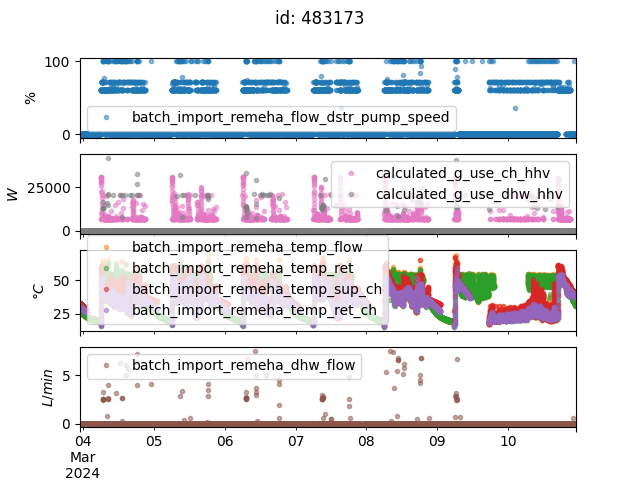

In [9]:
Plot.dataframe_preprocessed_plot(df_prep[returntemp_mask][['batch_import_remeha_flow_dstr_pump_speed__%',
                                                           'batch_import_remeha_temp_flow__degC',
                                                           'batch_import_remeha_temp_ret__degC',
                                                           'batch_import_remeha_temp_flow_ch__degC',
                                                           'batch_import_remeha_temp_ret_ch__degC',
                                                           'batch_import_remeha_dhw_flow__l_min_1',
                                                           'calculated_g_use_ch_hhv__W',
                                                           'calculated_g_use_dhw_hhv__W']
                                 ], units_to_mathtext)

### Create a mask for data from which heat distribution characteristics can be learned

In [ ]:
%%time
# Define the columns and conditions
include_cols = ['batch_import_remeha_boiler_status_burning_ch__bool', 'batch_import_remeha_boiler_status_pump_post_run__bool']
exclude_cols = ['batch_import_remeha_boiler_status_burning_dhw__bool']
pump_col = 'batch_import_remeha_flow_dstr_pump_speed__%'
dhw_flow = 'batch_import_remeha_dhw_flow__l_min_1'

# Define n (number of minutes to exclude per streak)
n = 5

# Step 1: Create the initial mask
include_mask = df_prep[include_cols].any(axis=1)  # At least one inclusion column is True
exclude_mask = df_prep[exclude_cols].any(axis=1)  # Any exclusion column is True
pump_mask = (df_prep[pump_col] > 0) & (df_prep[pump_col] < 100)  # Pump must be on, but not 100% for dhw
dhw_not_flow_mask = ~(df_prep[dhw_flow] > 0)

# Combine the masks
initial_mask = include_mask & ~exclude_mask & pump_mask & dhw_not_flow_mask

# Step 2: Ensure streaks are calculated per `id`
id_array = df_prep.index.get_level_values('id').to_numpy()  # Extract the `id` level
streak_ids = (~initial_mask).cumsum() + (id_array != np.roll(id_array, 1)).cumsum()  # Unique streak IDs per `id`

# Step 3: Exclude the first n rows of each streak
valid_indices = np.full_like(initial_mask, True)  # Start with all rows as valid

In [ ]:
%%time
# Create a DataFrame to hold streak_ids and their corresponding indices
streak_df = pd.DataFrame({
    'streak_ids': streak_ids,
    'mask': initial_mask
}, index=df_prep.index).reset_index()  # Reset index to make `id` a column

# Filter streak_df to include only valid streaks
streak_df = streak_df[streak_df['mask']]  # Keep only rows where initial_mask is True

# Rank rows within each streak (and id) to determine position within the streak
streak_df['rank'] = streak_df.groupby(['id', 'streak_ids']).cumcount()

# Identify rows to exclude (rank < n)
exclude_streak_rows = streak_df['rank'] < n

# Build the final valid_indices mask
valid_indices = ~exclude_streak_rows.reindex(index=np.arange(len(df_prep)), fill_value=False).to_numpy()

learn_heat_dstr_mask = initial_mask & valid_indices

In [ ]:
# Apply the final mask to df_prep
df_prep_heat_dstr = df_prep[learn_heat_dstr_mask]

In [ ]:
len(df_prep_heat_dstr)/len(df_prep)

In [ ]:
# time mask for one week in winter with almost all ids having data
filtered_returntemp_plot_mask = (
    (df_prep_heat_dstr.index.get_level_values('id') == 483173)
    & 
    (df_prep_heat_dstr.index.get_level_values('timestamp') >= pd.to_datetime('2024-03-04 00:00:00+01:00'))
    & 
    (df_prep_heat_dstr.index.get_level_values('timestamp') < pd.to_datetime('2024-03-11 00:00:00+01:00'))
)


In [ ]:
returntemp_plot_columns = ['batch_import_remeha_flow_dstr_pump_speed__%',
                           'batch_import_remeha_temp_flow__degC',
                           'batch_import_remeha_temp_ret__degC',
                           'batch_import_remeha_temp_flow_ch__degC',
                           'batch_import_remeha_temp_ret_ch__degC',
                           'batch_import_remeha_dhw_flow__l_min_1',
                           'calculated_g_use_ch_hhv__W',
                           'calculated_g_use_dhw_hhv__W']

In [ ]:
df_prep_heat_dstr[filtered_returntemp_plot_mask][returntemp_plot_columns].describe().T

In [ ]:
Plot.dataframe_preprocessed_plot(df_prep_heat_dstr[filtered_returntemp_plot_mask][returntemp_plot_columns], units_to_mathtext)

In [ ]:
df_prep_heat_dstr[returntemp_plot_columns].describe().T

In [ ]:
Plot.dataframe_preprocessed_plot(df_prep_heat_dstr[returntemp_plot_columns], units_to_mathtext)

### Inspect relation between flow_dstr_pump_speed__% and calcualted_flow_ch__dm3_min_1

In [ ]:
df_prep['batch_import_remeha_flow_dstr_pump_speed__%'].describe()

In [ ]:
df_prep[df_prep['batch_import_remeha_boiler_status_burning_dhw__bool']==True]['batch_import_remeha_flow_dstr_pump_speed__%'].describe()

In [ ]:
%matplotlib inline
%matplotlib widget
prop = 'batch_import_remeha_flow_dstr_pump_speed__%'
df_prep[df_prep['batch_import_remeha_boiler_status_burning_dhw__bool']==True][prop].plot.hist(bins=200, alpha=0.5, title = prop)


In [ ]:
df_homes_boilers = pd.read_excel(home_boilers_excel_file_path).rename(columns={'pseudonym': 'id'})

In [ ]:
df_homes_boilers = df_homes_boilers.rename(columns={'hydronic_ pump_model': 'hydronic_pump_model'})

In [ ]:
df_homes_boilers.columns.to_list()

In [ ]:
%%time
# Ensure that the necessary columns exist in both DataFrames
columns_to_merge = ['brand_model', 'hydronic_pump_brand', 'hydronic_pump_model']

if not all(col in df_homes_boilers.columns for col in columns_to_merge):
    print("Some required columns are missing in df_homes_boilers!")
else:
    # Step 1: Reset the index of df_prep to make brand_model a normal column
    df_prep = df_prep.reset_index()  # Resets 'id' and 'timestamp'

    # Step 2: Merge df_prep_reset with df_homes_boilers on 'brand_model'
    df_prep = pd.merge(
        df_prep,              # The DataFrame we're merging into
        df_homes_boilers[columns_to_merge],  # Only keeping relevant columns from df_homes_boilers
        how='left',                 # Use 'left' join to keep all rows from df_prep
        on='brand_model'            # The column to join on
    )

    # Convert specific object columns to categorical
    df_prep['hydronic_pump_brand'] = df_prep['hydronic_pump_brand'].astype('category')
    df_prep['hydronic_pump_model'] = df_prep['hydronic_pump_model'].astype('category')

    # Step 3: Set the 'id' and 'timestamp' columns back to MultiIndex
    df_prep = df_prep.set_index(['id', 'timestamp'])

In [ ]:
required_columns = ['batch_import_remeha_flow_dstr_pump_speed__%', 'calculated_flow_dstr__dm3_min_1']
# color_by = 'hydronic_pump_brand'
color_by = 'hydronic_pump_model'

if not all(col in df_prep.columns for col in required_columns):
    print("Some required columns are missing!")

df_sample = df_prep.sample(n=1000000, random_state=42)

plt.figure(figsize=(10, 6))

# Create a unique color palette for each brand using matplotlib's colormap
brands = df_sample[color_by].cat.categories
num_brands = len(brands)

# Use a colormap from matplotlib
cmap = plt.get_cmap('tab10', num_brands)  # 'tab10' is good for discrete categories

# Scatter plot with color based on 'hydronic_pump_brand'
for idx, brand in enumerate(brands):
    brand_data = df_sample[df_sample[color_by] == brand]
    plt.scatter(brand_data['batch_import_remeha_flow_dstr_pump_speed__%'], 
                brand_data['calculated_flow_dstr__dm3_min_1'], 
                color=cmap(idx),  # Use the colormap to get the color for the current brand
                alpha=0.5, s=1, label=brand)  # Label for legend
    
plt.title('Scatter plot of Water Pump Speed vs. Calculated Flow (all ids)')
plt.xlabel('batch_import_remeha_flow_dstr_pump_speed__%')
plt.ylabel('calculated_flow_dstr__dm3_min_1')
plt.grid(True)

# Add a legend
plt.legend(title=color_by, loc='best', markerscale=5)

plt.show()

## Learn heat performance signature parameters
Most of the heavy lifting is done by the `learn_heat_performance_signature()` function, which again uses the [GEKKO Python](https://machinelearning.byu.edu/) dynamic optimization toolkit.

In [ ]:
# If room metadata is set to None, then learn_home_parameters() will derive the metadata from the ids.
%autoreload 2

hints = {
    'heat_tr_bldng_cond__W_K_1':    heat_tr_bldng_nl_avg__W_K_1,         # specific heat loss of the building via conduction
    'th_inert_bldng__h':            th_inert_bldng_nl_avg__h,            # thermal inertia
    'aperture_sol__m2':             aperture_sol_nl_avg__m2,             # apparent solar aperture
    'wind_chill__K_s_m_1':          wind_chill_nl_avg__K_s_m_1,          # wind chill factor
    'aperture_inf__cm2':            aperture_inf_nl_avg__cm2,            # effective infiltration area 
    'occupancy__p':                 occupancy_nl_avg__p,                 # house occupancy
    'heat_int__W_p_1':              heat_int_nl_avg__W_p_1,              # heat gain per occupant
    'eta_ch_hhv__W0':               eta_ch_nl_avg_hhv__W0,               # home heating efficiency of a gas boiler (based on higher heating value)
    'eta_dhw_hhv__W0':              eta_dhw_nl_avg_hhv__W0,              # domestic hot water efficiency
    'frac_remain_dhw__0':           frac_remain_dhw_nl_avg__0,           # fraction of domestic hot water heat contributing to heating the home
    'g_use_cooking_hhv__W':         g_use_cooking_nl_avg_hhv__W,         # gas power (higher heating value) for cooking 
    'eta_cooking_hhv__W0':          eta_cooking_nl_avg_hhv__W0,          # cooking efficiency
    'frac_remain_cooking__0':       frac_remain_cooking_nl_avg__0,       # fraction of cooking heat contributing to heating the home
    'heat_tr_dstr__W_K_1':          heat_tr_dstr_nl_avg__W_K_1,          # heat dissipation capacity of the heat distribution system
    'th_mass_dstr__Wh_K_1':         th_mass_dstr_nl_avg__Wh_K_1,         # thermal mass of the heat distribution system
    'ventilation_default__dm3_s_1': 7.0,                                 # default ventilation rate for the entire home
    'ventilation_max__dm3_s_1_m_2': 1.0,                                 # maximum ventilation rate per m2 floor area
    'co2_outdoor__ppm':             co2_outdoor_eu_avg_2022__ppm,        # average CO₂ outdoor concentration
}

learn = [
    'heat_tr_bldng_cond__W_K_1',
    'th_inert_bldng__h',
    'th_mass_bldng__Wh_K_1',
    'aperture_sol__m2',
    'aperture_inf__cm2',
    'ventilation__dm3_s_1',
    # 'heat_tr_dstr__W_K_1', 'th_mass_dstr__J_K_1',
]


learned_parameters = [f'learned_{prop}' for prop in learn]

# select which property columns in df_prep are used as properties needed by the learning algorithm
property_sources = {
    'temp_indoor__degC':    'batch_import_remeha_temp_indoor__degC',
    'temp_set__degC':       'batch_import_remeha_temp_set__degC',
    'comfortable__bool':    'calculated_comfortable__bool',
    'temp_outdoor__degC':   'batch_import_KNMI_temp_outdoor__degC',
    'wind__m_s_1':          'batch_import_KNMI_wind__m_s_1',
    'sol_ghi__W_m_2':       'batch_import_KNMI_sol_ghi__W_m_2', 
    'g_use_ch_hhv__W':      'calculated_g_use_ch_hhv__W',
    'eta_ch_hhv__W0':       'eta_ch_hhv__W0', 
    'g_use_dhw_hhv__W':     'calculated_g_use_dhw_hhv__W',
    'e__W':                 'calculated_device_p1-reader_e__W',    
    'occupancy__p':         'device_living_room_occupancy__p',
    'co2_indoor__ppm':      'device_living_room_co2_indoor__ppm',
    'temp_flow_ch__degC':    'batch_import_remeha_temp_flow_ch__degC',
    'temp_ret_ch__degC':    'batch_import_remeha_temp_ret_ch__degC',
    'temp_flow_ch_max__degC':'batch_import_remeha_temp_flow_ch_max__degC', 
}

In [ ]:
props = list(property_sources.values())

In [ ]:
req_props = props.copy()
exclude_from_req_props = ['batch_import_remeha_temp_flow_ch__degC', 'batch_import_remeha_temp_ret_ch__degC', 'batch_import_remeha_temp_ch_max__degC']
for prop in exclude_from_req_props:
    if prop in req_props:
        req_props.remove(prop)

In [ ]:
%%time 
df_home_bag_data = pd.read_excel(home_BAG_data_file_path,  index_col='id')

### Define (subsets of) learning periods and (subsets of) home ids to perform the learning on

In [ ]:
# time mask for core of winter with most data
janfebmrt24_mask = ((df_prep.index.get_level_values('timestamp') >= pd.to_datetime('2024-01-01 00:00:00+01:00')) 
                    & 
                    (df_prep.index.get_level_values('timestamp') < pd.to_datetime('2024-04-01 00:00:00+02:00'))
                   )

In [ ]:
# time mask for one week in winter with almost all ids having data
febwk3_mask = ((df_prep.index.get_level_values('timestamp') >= pd.to_datetime('2024-02-18 00:00:00+01:00'))
               & 
               (df_prep.index.get_level_values('timestamp') < pd.to_datetime('2024-02-25 00:00:00+01:00'))
              )


In [ ]:
# time mask for one week in winter with almost all ids having data
feb_mask = ((df_prep.index.get_level_values('timestamp') >= pd.to_datetime('2024-02-01 00:00:00+01:00'))
            & 
            (df_prep.index.get_level_values('timestamp') < pd.to_datetime('2024-02-29 00:00:00+01:00'))
           )


In [ ]:
specific_id = 434931
specific_ids = [434931, 450298, 495906]

### Check presence of properties

In [ ]:
Plot.plot_missing_data_overview(df_prep[janfebmrt24_mask], properties_include=req_props, freq='1W', title_fontsize=8)

In [ ]:
df_prep[febwk3_mask][props].xs(specific_id, level='id', drop_level=False).describe().T

In [ ]:
df_prep[feb_mask][props].xs(specific_id, level='id', drop_level=False).describe().T

In [ ]:
df_prep[janfebmrt24_mask][props].xs(specific_id, level='id', drop_level=False).describe().T

In [ ]:
Plot.dataframe_preprocessed_plot(df_prep[feb_mask][props].xs(specific_id, level='id', drop_level=False), units_to_mathtext)

### Use GEKKO model to learn the heat performance signature parameters

In [ ]:
hints

In [ ]:
th_inert_dstr_nl_avg__h = hints['th_mass_dstr__Wh_K_1']  / hints['heat_tr_dstr__W_K_1']
th_inert_dstr_nl_avg__h

In [ ]:
props

In [ ]:
req_props

In [ ]:
learn

In [ ]:
df_prep.info()

In [ ]:
specific_ids

In [ ]:
# learn the model parameters and write results to a dataframe
idx = pd.IndexSlice
# df_prep_analyze = df_prep[febwk3_mask][props].loc[idx[[specific_id]], :]
# df_prep_analyze = df_prep[febwk3_mask][props].loc[idx[specific_ids], :]
df_prep_analyze = df_prep[feb_mask][props].loc[idx[specific_ids], :]                                                                
# df_prep_analyze = df_prep[janfebmrt24_mask][props]                                                                             

In [ ]:
#define the length of the learning period
learn_period__d=7
# learn_period__d=3


In [ ]:
%%time
%autoreload 2
# Start the actual learning
df_results_per_period, df_results = Learner.learn_heat_performance_signature(
    df_prep_analyze,  # This is the selected DataFrame based on the uncommented line
    property_sources=property_sources,
    df_bldng_data=df_home_bag_data,
    learn=learn, 
    hints=hints,
    learn_period__d=learn_period__d,
    learn_change_interval__min=30,
    req_col=req_props,
    # complete_most_recent_analysis=True,  # Uncomment if needed
    parallel = True # Comment out or set to false if you do not want parallel execution of learning
)

In [ ]:
df_results_per_period.sort_index()

In [ ]:
df_results_per_period.describe().T

In [ ]:
df_results_per_period[['learned_avg_energy_ch__W', 'learned_avg_heat_sol__W','learned_avg_heat_int__W']].mean().T

In [ ]:
%%time 
# Convert all datetime columns to timezone-naive
df_results_per_period_no_tz = df_results_per_period.reset_index(drop=False).apply(lambda x: x.dt.tz_localize(None) if x.dtype.kind == 'M' else x)

# Export to Excel
df_results_per_period_no_tz.to_excel(rhc_analysis_results_per_period_file, index=False)


In [ ]:
%%time 
#TODO: check whether this is still needed; results are available in subdirs?
df_results.to_parquet(rhc_analysis_results_file, index=True, engine='pyarrow')

In [ ]:
df_results_per_period_no_tz

## Visualize learned heat performance signature parameters

### (optional) Read results

In [ ]:
%%time

# Attempt to read the Parquet file
try:
    df_results = pd.read_parquet(
        rhc_analysis_results_file, 
        engine='pyarrow',
        dtype_backend='numpy_nullable'
        )
    print("File was successfully read without specifying compression codec.")
except Exception as e:
    print(f"Error reading file: {e}")

In [ ]:
%%time 
df_results_per_period = pd.read_excel(rhc_analysis_results_per_period_file)

# Re-apply the timezone to the 'start' and 'end' columns
df_results_per_period['start'] = pd.to_datetime(df_results_per_period['start']).dt.tz_localize('Europe/Amsterdam')
df_results_per_period['end'] = pd.to_datetime(df_results_per_period['end']).dt.tz_localize('Europe/Amsterdam')

# Set MultiIndex again
df_results_per_period.set_index(['id', 'start', 'end'], inplace=True)

In [ ]:
df_results_per_period.columns.to_list()

In [ ]:
df_results_per_period

In [ ]:
df_results_per_period.describe().T

### Calculate how well parameters were learned

In [ ]:
# show essential statistics for the errors; all homeperiods combined
df_results_per_period[['mae_temp_indoor__degC', 'rmse_temp_indoor__degC']].describe()

In [ ]:
# show essential statistics for the errors; all periods per home
df_results_per_period[['mae_temp_indoor__degC', 'rmse_temp_indoor__degC']].groupby('id').describe().T

## Add correction factors to make periods comparable

In [ ]:
# Calculate period length in seconds using the 'end' and 'start' MultiIndex levels
df_results_per_period['period__s'] = (df_results_per_period.index.get_level_values('end') - df_results_per_period.index.get_level_values('start')).total_seconds()
df_results_per_period['period__d'] = df_results_per_period['period__s'] / s_d_1

In [ ]:
# Calculate total period duration per `id`
total_period__s = df_results_per_period.groupby('id')['period__s'].transform('sum')

In [ ]:
# Calculate `period_avg_int_heat__K`, `period_avg_inf_chill__K`, and `period_avg_vent_chill__K` with division by `learned_heat_tr_bldng_cond__W_K_1`
df_results_per_period['period_avg_int_heat__K'] = np.where(
    df_results_per_period['learned_heat_tr_bldng_cond__W_K_1'] != 0,
    df_results_per_period['learned_avg_heat_int__W'] / df_results_per_period['learned_heat_tr_bldng_cond__W_K_1'],
    np.nan
)

df_results_per_period['period_avg_inf_chill__K'] = np.where(
    df_results_per_period['learned_heat_tr_bldng_cond__W_K_1'] != 0,
    df_results_per_period['learned_avg_heat_loss_bldng_inf__W'] / df_results_per_period['learned_heat_tr_bldng_cond__W_K_1'],
    np.nan
)

df_results_per_period['period_avg_vent_chill__K'] = np.where(
    df_results_per_period['learned_heat_tr_bldng_cond__W_K_1'] != 0,
    df_results_per_period['learned_avg_heat_loss_bldng_vent__W'] / df_results_per_period['learned_heat_tr_bldng_cond__W_K_1'],
    np.nan
)

In [ ]:
# Calculate the weighted sums
df_results_per_period['int_heat__K_s'] = df_results_per_period['period_avg_int_heat__K'] * df_results_per_period['period__s']
df_results_per_period['inf_chill__K_s'] = df_results_per_period['period_avg_inf_chill__K'] * df_results_per_period['period__s']
df_results_per_period['vent_chill__K_s'] = df_results_per_period['period_avg_vent_chill__K'] * df_results_per_period['period__s']
df_results_per_period['temp_outdoor__degC_s'] = df_results_per_period['learned_avg_temp_outdoor__degC'] * df_results_per_period['period__s']

In [ ]:
# Calculate time-weighted averages by dividing the weighted sums by `total_period__s`
df_results_per_period['all_periods_avg_int_heat__K'] = df_results_per_period.groupby('id')['int_heat__K_s'].transform('sum') / total_period__s
df_results_per_period['all_periods_avg_inf_chill__K'] = df_results_per_period.groupby('id')['inf_chill__K_s'].transform('sum') / total_period__s
df_results_per_period['all_periods_avg_vent_chill__K'] = df_results_per_period.groupby('id')['vent_chill__K_s'].transform('sum') / total_period__s
df_results_per_period['all_periods_avg_temp_outdoor__degC'] = df_results_per_period.groupby('id')['temp_outdoor__degC_s'].transform('sum') / total_period__s

In [ ]:
# Calculate period heat demand
df_results_per_period['period_heat_demand__K'] = (
    df_results_per_period['learned_avg_indoor_outdoor_delta__K'] +
    df_results_per_period['period_avg_inf_chill__K'] +
    df_results_per_period['period_avg_vent_chill__K'] -
    df_results_per_period['period_avg_int_heat__K']
).clip(lower=0)

In [ ]:
# Calculate period corrected heat demand 
df_results_per_period['corrected_heat_demand__K'] = (
    df_results_per_period['learned_avg_indoor_outdoor_delta__K'] +
    df_results_per_period['all_periods_avg_inf_chill__K'] +
    df_results_per_period['all_periods_avg_vent_chill__K'] -
    df_results_per_period['all_periods_avg_int_heat__K'] +
    (df_results_per_period['learned_avg_temp_outdoor__degC'] - df_results_per_period['all_periods_avg_temp_outdoor__degC'])
).clip(lower=0)

In [ ]:
# Calculate the correction factor, avoiding division by zero
df_results_per_period['energy_ch_correction_factor__0'] = np.where(
    df_results_per_period['period_heat_demand__K'] != 0,
    df_results_per_period['corrected_heat_demand__K'] / df_results_per_period['period_heat_demand__K'],
    1.0  # Default to 1.0 if period_heat_demand__K is zero to avoid division by zero
)

In [ ]:
# Apply the correction factor to calculate corrected_avg_energy_ch__W and corrected_avg_co2_ch__g_s_1
df_results_per_period['corrected_avg_energy_ch__W'] = (
    df_results_per_period['learned_avg_energy_ch__W'] * df_results_per_period['energy_ch_correction_factor__0']
)
df_results_per_period['corrected_avg_co2_ch__g_s_1'] = (
    df_results_per_period['learned_avg_co2_ch__g_s_1'] * df_results_per_period['energy_ch_correction_factor__0']
)

In [ ]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(df_results_per_period.describe().T)


In [ ]:
# Optionally drop intermediate columns for a clean final DataFrame
# df_results_per_period = df_results_per_period.drop(columns=['period_avg_int_heat__K', 'period_avg_inf_chill__K', 'period_avg_vent_chill__K',
#                                                             'int_heat__K_s', 'inf_chill__K_s', 'vent_chill__K_s', 'temp_outdoor__degC_s',
#                                                             'heat_demand__K', 'corrected_heat_demand__K'])

## Visualize learned parameters (boxplots per id to illustrate variability)

In [ ]:
learned_parameters

In [ ]:
visualize_learned_parameters = [param for param in learned_parameters if param not in ['learned_ventilation__dm3_s_1']]

In [ ]:
visualize_learned_parameters

In [ ]:
df_results_per_period[visualize_learned_parameters].describe().T

In [ ]:
df_results_per_period[visualize_learned_parameters].groupby('id').describe().T

In [ ]:
for learned_prop in visualize_learned_parameters:
    Plot.nfh_property_per_id_boxplot(df_results_per_period, property_col=learned_prop)

### Visualization of learned/simulated temperatures

In [ ]:
df_results['learned_temp_indoor__degC'].groupby('id').count().to_frame().T

In [ ]:
if 'ventilation__dm3_s_1' in learn:
    display(df_results['learned_ventilation__dm3_s_1'].groupby('id').count().to_frame().T)
    display(df_results['learned_ventilation__dm3_s_1'].groupby('id').describe().T)

In [ ]:
if 'ventilation__dm3_s_1' in learn:
    df_results['learned_ventilation__dm3_s_1']

In [ ]:
#Plot only temperatures from all sources for all ids
if 'ventilation__dm3_s_1' in learn:
    Plot.dataframe_preprocessed_plot(df_results[['batch_import_remeha_temp_indoor__degC', 'learned_temp_indoor__degC', 'learned_ventilation__dm3_s_1']].xs(specific_id, level='id', drop_level=False), units_to_mathtext)
else:
    Plot.dataframe_preprocessed_plot(df_results[['batch_import_remeha_temp_indoor__degC', 'learned_temp_indoor__degC']].xs(specific_id, level='id', drop_level=False), units_to_mathtext)

## Visualize calculated metrics for Energy Case, Comfort Case and Carbon Case

In [ ]:
metrics = ['corrected_avg_energy_ch__W', 'learned_avg_comfortable__0', 'corrected_avg_co2_ch__g_s_1']

In [ ]:
df_results_per_period[metrics].groupby('id').describe().T

## Analyze and visualize intervention A1: change thermostat program

In [ ]:
# Load the regime change data from Excel
regime_changes_A1 = pd.read_excel(regime_change_A1_file_path)

In [ ]:
# Convert the program change datetime to a datetime object only if the datetime and timezone values are non-empty
regime_changes_A1['A_thermostat_program_change_datetime'] = pd.to_datetime(
    regime_changes_A1['A_thermostat_program_change_datetime'], errors='coerce'
)

# Apply timezone localization conditionally
regime_changes_A1['A_thermostat_program_change_datetime'] = regime_changes_A1.apply(
    lambda row: row['A_thermostat_program_change_datetime'].tz_localize(row['timezone'])
    if pd.notna(row['A_thermostat_program_change_datetime']) and pd.notna(row['timezone'])
    else row['A_thermostat_program_change_datetime'],
    axis=1
)

In [ ]:
regime_changes_A1 = regime_changes_A1.drop(columns=['timezone'])

In [ ]:
regime_changes_A1['regime_sequence_number'] = regime_changes_A1.groupby('id').cumcount() + 1

In [ ]:
regime_changes_A1

In [ ]:
# Label results per period with regime sequence numbers, if there was no regime change in the period

# Initialize the regime_sequence_number column
df_results_per_period['regime_sequence_number'] = None

# reset index
df_results_per_period = df_results_per_period.reset_index()

# Loop over each row in df_results_per_period
for index, row in df_results_per_period.iterrows():
    # Get the current id, start, and end for the row
    current_id = row['id']
    start_time = row['start']
    end_time = row['end']

    # Check for regime changes within the interval
    regime_changes = regime_changes_A1[
        (regime_changes_A1['id'] == current_id) &
        (regime_changes_A1['A_thermostat_program_change_datetime'] >= start_time) &
        (regime_changes_A1['A_thermostat_program_change_datetime'] <= end_time)
    ]

    # If there are regime changes, do not assign a regime sequence number
    if not regime_changes.empty:
        continue  # Skip assigning a regime sequence number for this interval

    # If there are no regime changes, find the latest regime sequence number before the start
    latest_regime = regime_changes_A1[
        (regime_changes_A1['id'] == current_id) &
        (regime_changes_A1['A_thermostat_program_change_datetime'] <= start_time)
    ].sort_values(by='A_thermostat_program_change_datetime', ascending=False)

    # Assign the regime sequence number if found
    if not latest_regime.empty:
        df_results_per_period.at[index, 'regime_sequence_number'] = latest_regime.iloc[0]['regime_sequence_number']



# Convert the regime_sequence_number column to integers
df_results_per_period['regime_sequence_number'] = pd.to_numeric(df_results_per_period['regime_sequence_number'], downcast='integer')

# restore the index
df_results_per_period = df_results_per_period.set_index(['id', 'start', 'end'])

In [ ]:
regime_changes_A1[['id', 'regime_sequence_number']].groupby('id').describe()

In [ ]:
df_results_per_period[['regime_sequence_number']].groupby('id').describe()

In [ ]:
# Group by 'id' and calculate standard deviation for 'regime_sequence_number'
std_values = regime_changes_A1.groupby('id')['regime_sequence_number'].std()

# Filter the ids where std > 0
id_mask_intervention_A1 = std_values[std_values > 0].index.tolist()

In [ ]:
df_results_per_period.columns.to_list()

In [ ]:
intervention_results_columns_a1 = (['regime_sequence_number',
                                 'period__d',
                                 'learned_avg_temp_set__degC',
                                 'learned_avg_temp_indoor__degC',
                                 'learned_avg_temp_outdoor__degC',
                                 'learned_avg_energy_ch__W',
                                 'learned_avg_co2_ch__g_s_1',
                                ] + metrics)

In [ ]:
df_results_per_a1_intervention = (df_results_per_period[df_results_per_period.index.get_level_values('id').isin(id_mask_intervention_A1)][intervention_results_columns_a1]
                                  .reset_index()
                                  .dropna(subset=['regime_sequence_number'])  # Drop rows where 'regime_sequence_number' is NaN
                                  .dropna(subset=metrics) # Drop rows where any of the metrics is NaN
                                  .set_index(['id', 'regime_sequence_number', 'start', 'end']))

In [ ]:
df_results_per_a1_intervention


In [ ]:
homes_with_thermostat_program_change = df_results_per_a1_intervention.index.get_level_values('id').unique().size
print(f"Number of homes that did a thermostat program change: {homes_with_thermostat_program_change}")
thermostat_programs_in_homes_with_thermostat_change = df_results_per_a1_intervention.index.to_frame(index=False)[['id', 'regime_sequence_number']].drop_duplicates().size
print(f"Number of thermostat programs of these homes: {thermostat_programs_in_homes_with_thermostat_change}")
if homes_with_thermostat_program_change >0:
    print(f"Average number of thermostat programs in homes with thermostat program change: {thermostat_programs_in_homes_with_thermostat_change/homes_with_thermostat_program_change}")

### Filter out learning periods that don't cover a full thermostat program 

In [ ]:
df_results_per_a1_intervention = df_results_per_a1_intervention[df_results_per_a1_intervention['period__d'] == learn_period__d]

### Aggregate regime metrics and keep only ids for which 2 or more regimes can be compared

In [ ]:
df_results_per_a1_intervention_grouped = df_results_per_a1_intervention.groupby(['id', 'regime_sequence_number']).agg({
        'period__d': 'sum',  # Summing this specific column
    **{col: 'mean' for col in df_results_per_a1_intervention.columns if col != 'period__d'}  # Mean for all other columns
})

# Step 1: Find unique regime counts per `id`
unique_counts = df_results_per_a1_intervention_grouped.index.to_frame(index=False).groupby('id')['regime_sequence_number'].nunique()

# Step 2: Identify `id`s with more than one unique regime_sequence_number
ids_with_multiple_regimes = unique_counts[unique_counts > 1].index

# Step 3: Filter the DataFrame to keep only rows with `id`s that have multiple regimes
df_results_per_a1_intervention_grouped = df_results_per_a1_intervention_grouped[df_results_per_a1_intervention_grouped.index.get_level_values('id').isin(ids_with_multiple_regimes)]

In [ ]:
df_results_per_a1_intervention_limited_grouped = df_results_per_a1_intervention_grouped

# df_results_per_a1_intervention_limited_grouped = df_results_per_a1_intervention_grouped[['period__d',
#  'learned_avg_temp_set__degC',
#  'learned_avg_temp_indoor__degC',
#  'learned_avg_temp_outdoor__degC',
#  'corrected_avg_energy_ch__W',
#  'learned_avg_comfortable__0',
#  'corrected_avg_co2_ch__g_s_1']]

In [ ]:
df_results_per_a1_intervention_limited_grouped

In [ ]:
%%time 
# Convert all datetime columns to timezone-naive and export to Excel
df_results_per_a1_intervention_limited_grouped.reset_index(drop=False).apply(lambda x: x.dt.tz_localize(None) if x.dtype.kind == 'M' else x).to_excel("results_interventions_A1.xlsx", index=False)

### Check thermostat program changes via temperature plots

In [ ]:
temp_property_sources_a1 = {
    'temp_indoor__degC':    'batch_import_remeha_temp_indoor__degC',
    'temp_set__degC':       'batch_import_remeha_temp_set__degC',
    # 'comfortable__bool':    'calculated_comfortable__bool',
    'temp_outdoor__degC':   'batch_import_KNMI_temp_outdoor__degC',
    # 'temp_flow_ch__degC':    'batch_import_remeha_temp_flow_ch__degC',
    # 'temp_ret_ch__degC':    'batch_import_remeha_temp_ret_ch__degC',
    # 'temp_flow_ch_max__degC':'batch_import_remeha_temp_flow_ch_max__degC', 
}

tempprops_a1 = list(temp_property_sources_a1.values())

In [ ]:
for id in df_results_per_a1_intervention_limited_grouped.index.get_level_values('id').unique():
    print(id)
    display(df_results_per_a1_intervention_limited_grouped.loc[id])
    Plot.dataframe_preprocessed_plot(df_prep[janfebmrt24_mask][tempprops_a1].xs(id, level='id', drop_level=False), units_to_mathtext)

In [ ]:
# Define your metrics and desired precisions in a dictionary
metrics_format = {
    'corrected_avg_energy_ch__W': '{:.0f}',  # 0 decimal places
    'learned_avg_comfortable__0': '{:.2f}',  # 2 decimal places
    'corrected_avg_co2_ch__g_s_1': '{:.3f}'  # 3 decimal places
}

# Loop through each metric, applying the specified precision
for metric, format_str in metrics_format.items():
    print(metric)
    with pd.option_context('display.float_format', format_str.format):
        display(df_results_per_a1_intervention[metric].groupby(['id', 'regime_sequence_number']).describe().T)


In [ ]:
# Plot.calculated_intervention_metrics_boxplot(df_results_per_a1_intervention_limited_grouped, metrics)

## Analyze and visualize intervention B1: lower maximum supply temperatures

In [ ]:
# Load the regime change data from Excel
regime_changes_B1 = pd.read_excel(regime_change_B1_file_path)

In [ ]:
# Convert the program change datetime to a datetime object only if the datetime and timezone values are non-empty
regime_changes_B1['B_temp_flow_ch_max__datetime'] = pd.to_datetime(
    regime_changes_B1['B_temp_flow_ch_max__datetime'], errors='coerce'
)

# Apply timezone localization conditionally
regime_changes_B1['B_temp_flow_ch_max__datetime'] = regime_changes_B1.apply(
    lambda row: row['B_temp_flow_ch_max__datetime'].tz_localize(row['timezone'])
    if pd.notna(row['B_temp_flow_ch_max__datetime']) and pd.notna(row['timezone'])
    else row['B_temp_flow_ch_max__datetime'],
    axis=1
)

In [ ]:
regime_changes_B1 = regime_changes_B1.drop(columns=['timezone'])

In [ ]:
regime_changes_B1['regime_sequence_number'] = regime_changes_B1.groupby('id').cumcount() + 1

In [ ]:
regime_changes_B1

In [ ]:
# Label results per period with regime sequence numbers, if there was no regime change in the period

# Initialize the regime_sequence_number column
df_results_per_period['regime_sequence_number'] = None

# reset index
df_results_per_period = df_results_per_period.reset_index()

# Loop over each row in df_results_per_period
for index, row in df_results_per_period.iterrows():
    # Get the current id, start, and end for the row
    current_id = row['id']
    start_time = row['start']
    end_time = row['end']

    # Check for regime changes within the interval
    regime_changes = regime_changes_B1[
        (regime_changes_B1['id'] == current_id) &
        (regime_changes_B1['B_temp_flow_ch_max__datetime'] >= start_time) &
        (regime_changes_B1['B_temp_flow_ch_max__datetime'] <= end_time)
    ]

    # If there are regime changes, do not assign a regime sequence number
    if not regime_changes.empty:
        continue  # Skip assigning a regime sequence number for this interval

    # If there are no regime changes, find the latest regime sequence number before the start
    latest_regime = regime_changes_B1[
        (regime_changes_B1['id'] == current_id) &
        (regime_changes_B1['B_temp_flow_ch_max__datetime'] <= start_time)
    ].sort_values(by='B_temp_flow_ch_max__datetime', ascending=False)

    # Assign the regime sequence number if found
    if not latest_regime.empty:
        df_results_per_period.at[index, 'regime_sequence_number'] = latest_regime.iloc[0]['regime_sequence_number']



# Convert the regime_sequence_number column to integers
df_results_per_period['regime_sequence_number'] = pd.to_numeric(df_results_per_period['regime_sequence_number'], downcast='integer')

# restore the index
df_results_per_period = df_results_per_period.set_index(['id', 'start', 'end'])

In [ ]:
regime_changes_B1[['id', 'regime_sequence_number']].groupby('id').describe()

In [ ]:
df_results_per_period[['regime_sequence_number']].groupby('id').describe()

In [ ]:
# Group by 'id' and calculate standard deviation for 'regime_sequence_number'
std_values = regime_changes_B1.groupby('id')['regime_sequence_number'].std()

# Filter the ids where std > 0
id_mask_intervention_B1 = std_values[std_values > 0].index.tolist()

In [ ]:
df_results_per_period.columns.to_list()

In [ ]:
intervention_results_columns_b1 = (['regime_sequence_number',
                                 'period__d',
                                 'learned_avg_temp_flow_ch_max__degC',
                                 'learned_avg_temp_indoor__degC',
                                 'learned_avg_temp_outdoor__degC',
                                 'learned_avg_energy_ch__W',
                                 'learned_avg_co2_ch__g_s_1',
                                ] + metrics)

In [ ]:
df_results_per_b1_intervention = (df_results_per_period[df_results_per_period.index.get_level_values('id').isin(id_mask_intervention_B1)][intervention_results_columns_b1]
                                  .reset_index()
                                  .dropna(subset=['regime_sequence_number'])  # Drop rows where 'regime_sequence_number' is NaN
                                  .dropna(subset=metrics) # Drop rows where any of the metrics is NaN
                                  .set_index(['id', 'regime_sequence_number', 'start', 'end']))

In [ ]:
df_results_per_b1_intervention

In [ ]:
homes_with_max_flow_temp_change = len(df_results_per_b1_intervention.index.get_level_values('id').unique())
print(f"Number of homes that changed their max supply temperature: {homes_with_max_flow_temp_change}")
max_flow_temp_regimes_in_homes_with_max_flow_temp_change = len(df_results_per_b1_intervention.index.to_frame(index=False)[['id', 'regime_sequence_number']].drop_duplicates())
print(f"Number of max supply temperature settings in these homes: {max_flow_temp_regimes_in_homes_with_max_flow_temp_change}")
if homes_with_max_flow_temp_change >0:
    print(f"Average number of max supply temperatures settings in homes with such a change: {max_flow_temp_regimes_in_homes_with_max_flow_temp_change/homes_with_max_flow_temp_change}")


### Filter out learning periods that don't cover a period - 1 day

In [ ]:
df_results_per_b1_intervention = df_results_per_b1_intervention[df_results_per_b1_intervention['period__d'] > (learn_period__d - 1)]


In [ ]:
df_results_per_b1_intervention

### Aggregate regime metrics and keep only ids for which 2 or more regimes can be compared

In [ ]:
df_results_per_b1_intervention_grouped = df_results_per_b1_intervention.groupby(['id', 'regime_sequence_number']).agg({
        'period__d': 'sum',  # Summing this specific column
    **{col: 'mean' for col in df_results_per_b1_intervention.columns if col != 'period__d'}  # Mean for all other columns
})

# Step 1: Find unique regime counts per `id`
unique_counts = df_results_per_b1_intervention_grouped.index.to_frame(index=False).groupby('id')['regime_sequence_number'].nunique()

# Step 2: Identify `id`s with more than one unique regime_sequence_number
ids_with_multiple_regimes = unique_counts[unique_counts > 1].index

# Step 3: Filter the DataFrame to keep only rows with `id`s that have multiple regimes
df_results_per_b1_intervention_grouped = df_results_per_b1_intervention_grouped[df_results_per_b1_intervention_grouped.index.get_level_values('id').isin(ids_with_multiple_regimes)]

In [ ]:
df_results_per_b1_intervention_limited_grouped = df_results_per_b1_intervention_grouped

# df_results_per_a1_intervention_limited_grouped = df_results_per_a1_intervention_grouped[['period__d',
#  'learned_avg_temp_flow_ch_max__degC',
#  'learned_avg_temp_indoor__degC',
#  'learned_avg_temp_outdoor__degC',
#  'corrected_avg_energy_ch__W',
#  'learned_avg_comfortable__0',
#  'corrected_avg_co2_ch__g_s_1']]

In [ ]:
df_results_per_b1_intervention_limited_grouped

In [ ]:
%%time 
# Convert all datetime columns to timezone-naive and export to Excel
df_results_per_b1_intervention_limited_grouped.reset_index(drop=False).apply(lambda x: x.dt.tz_localize(None) if x.dtype.kind == 'M' else x).to_excel("results_interventions_B1.xlsx", index=False)

In [ ]:
# Define your metrics and desired precisions in a dictionary
metrics_format = {
    'corrected_avg_energy_ch__W': '{:.0f}',  # 0 decimal places
    'learned_avg_comfortable__0': '{:.2f}',  # 2 decimal places
    'corrected_avg_co2_ch__g_s_1': '{:.3f}'  # 3 decimal places
}

# Loop through each metric, applying the specified precision
for metric, format_str in metrics_format.items():
    print(metric)
    with pd.option_context('display.float_format', format_str.format):
        display(df_results_per_b1_intervention[metric].groupby(['id', 'regime_sequence_number']).describe().T)


In [ ]:
temp_property_sources_b1 = {
    'temp_indoor__degC':    'batch_import_remeha_temp_indoor__degC',
    'temp_set__degC':       'batch_import_remeha_temp_set__degC',
    # 'comfortable__bool':    'calculated_comfortable__bool',
    'temp_outdoor__degC':   'batch_import_KNMI_temp_outdoor__degC',
    'temp_flow_ch__degC':    'batch_import_remeha_temp_flow_ch__degC',
    'temp_ret_ch__degC':    'batch_import_remeha_temp_ret_ch__degC',
    'temp_flow_ch_max__degC':'batch_import_remeha_temp_flow_ch_max__degC', 
}

tempprops_b1 = list(temp_property_sources_b1.values())

In [ ]:
for id in df_results_per_b1_intervention_limited_grouped.index.get_level_values('id').unique():
    print(id)
    display(df_results_per_b1_intervention_limited_grouped.loc[id])
    Plot.dataframe_preprocessed_plot(df_prep[janfebmrt24_mask][tempprops_b1].xs(id, level='id', drop_level=False), units_to_mathtext)

In [ ]:
# Plot.calculated_intervention_metrics_boxplot(df_results_per_b1_intervention_limited_grouped, metrics)